In [1]:
pip install matrixmethod


  Using cached matrixmethod-0.1.2-py3-none-any.whl.metadata (928 bytes)
  Using cached numba-0.62.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.8 kB)
  Using cached numpy-2.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached llvmlite-0.45.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (4.9 kB)
Using cached matrixmethod-0.1.2-py3-none-any.whl (15 kB)
Using cached numba-0.62.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.5 MB)
Using cached llvmlite-0.45.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (56.3 MB)
Using cached numpy-2.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: llvmlite━━━━━━━━━━━━━━━━ 0/4 [numpy]
    Found existing installation: llvmlite 0.43.0 0/4 [nump

In [1]:
import sys
sys.path.append("../src")  # relative path from notebooks/ to src/
from reflectivity_model import LayerSpec, ReflectivityModel, eVnm_converter,extract_nk_arrays,load_nk_from_file,normalize_polarization
import reflectivity_model.utils as utils
import reflectivity_model.xray_compounds as xc
import json

import numpy as np
from os import listdir
from os.path import isfile, join, expanduser
import pandas as pd
import matplotlib.pyplot as plt
import pint
unit = pint.UnitRegistry()
from scipy.optimize import differential_evolution, minimize
import objective

#home = expanduser("~")
#sys.path.append(join(home,'Projects/'))
#import matrixmethod.mm_numba as mm #https://github.com/mikapfl/matrixmethod

### Import exp data

In [2]:
#ToDO: Check for polairzation if nothing is given, set it to s pol 100=s 190=p


# Sample and path configuration
sample_name = '2layers' 
path = '../data/'

# Filter relevant CSV files
onlyfiles_keys = [
    f for f in listdir(path)
    if isfile(join(path, f)) and f.endswith('.csv') and f.startswith(sample_name)
]
print("Found files:", onlyfiles_keys)

labels = []
exp_data_all = []

# Process each file
for filename in onlyfiles_keys:
    label = filename[:-4]  # strip .csv
    full_path = join(path, filename)
    df = pd.read_csv(full_path)

    # Normalize column names
    df.rename(columns={
        'energy': 'Energy',
        'sam_th': 'Theta'
    }, inplace=True)

    # Ensure polarization column exists
    if 'pol' not in df.columns:
        df['pol'] = 1  # default to s-polarization

    df['pol'] = df['pol'].apply(normalize_polarization)

    # Create combined energy/polarization label
    df['energy_pol'] = df.apply(
        lambda row: f"{row['Energy']}_{'p' if row['pol'] == 0 else 's'}",
        axis=1
    )

    # Filter theta range
    df = df[(df['Theta'] > 2.5) & (df['Theta'] < 30)]

    # Add metadata
    df['file_name'] = label
    df['E_round'] = np.round(df['Energy'], 1)

    labels.append(label)
    exp_data_all.append(df)

# Combine all dataframes
combined_df = pd.concat(exp_data_all, ignore_index=True)

# Extract unique energy values and labels
energy_uni = np.unique(combined_df['Energy'])
energy_pol_uni = np.unique(combined_df['energy_pol'])

# Derive ceremonial file name
split_file = labels[0].split('_')
file_name = '_'.join(split_file[:3])

# Optional: Display unique energy/polarization combinations
print("Unique energy/polarization labels:", energy_pol_uni)


Found files: ['2layers.csv']
Unique energy/polarization labels: ['250.0_s' '284.0_s' '284.2_s' '284.6_s' '285.0_s' '285.5_s' '286.0_s'
 '286.5_s' '287.0_s' '287.7_s' '288.6_s']


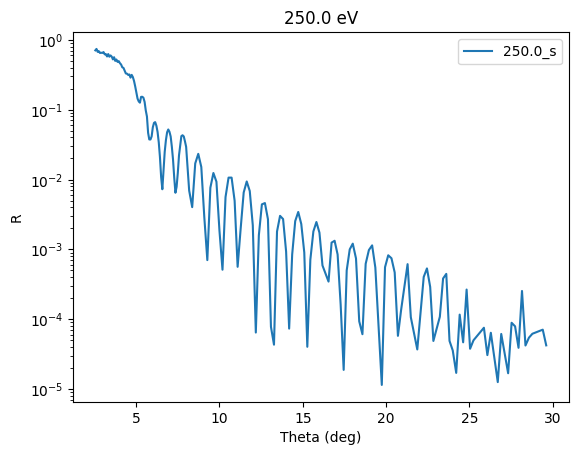

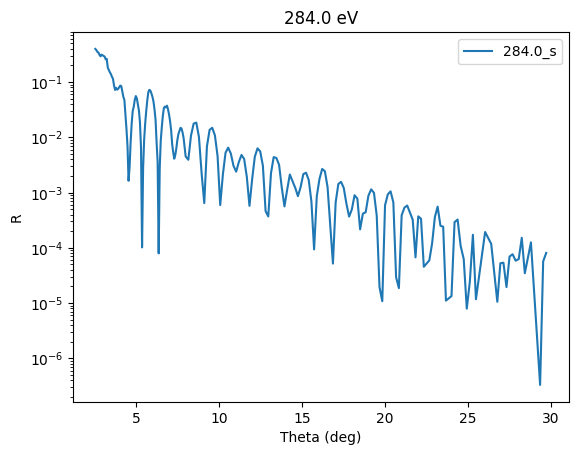

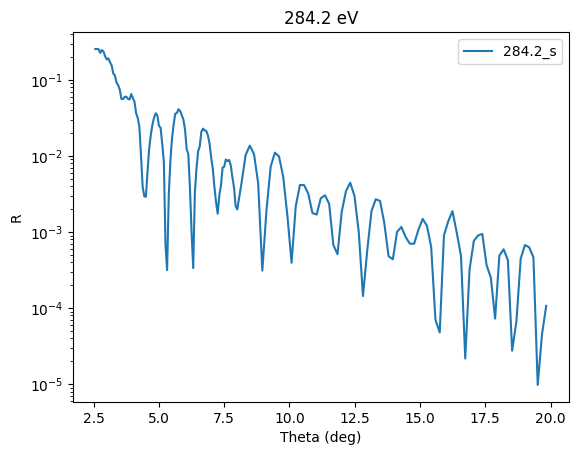

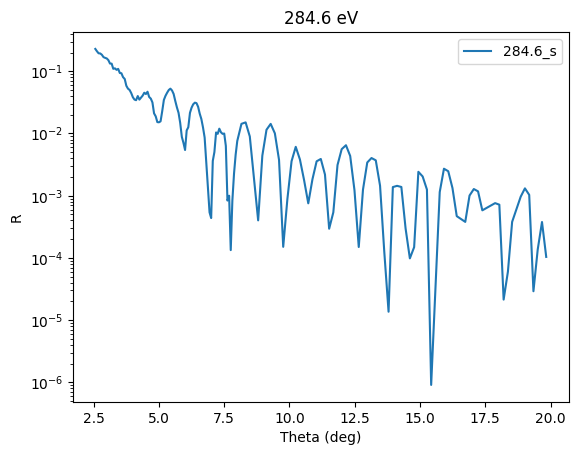

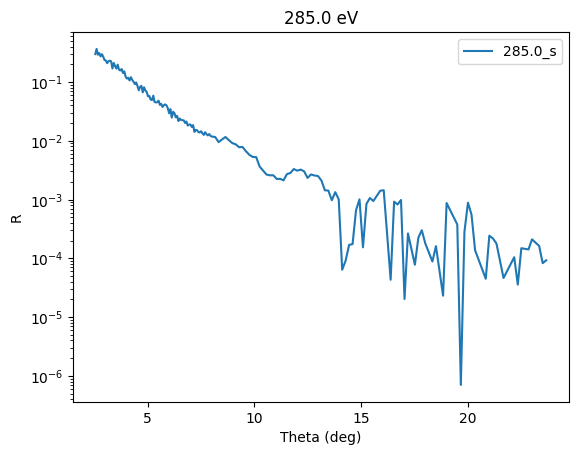

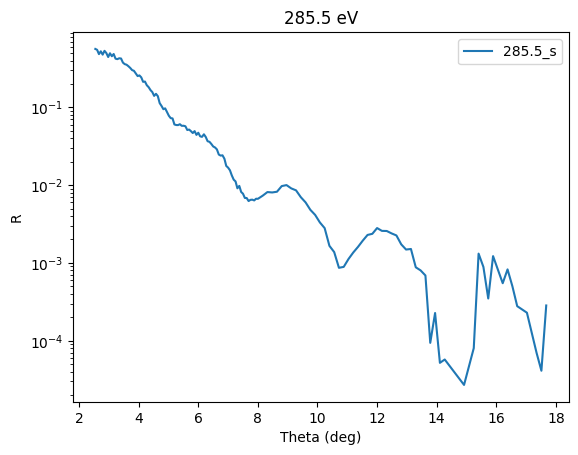

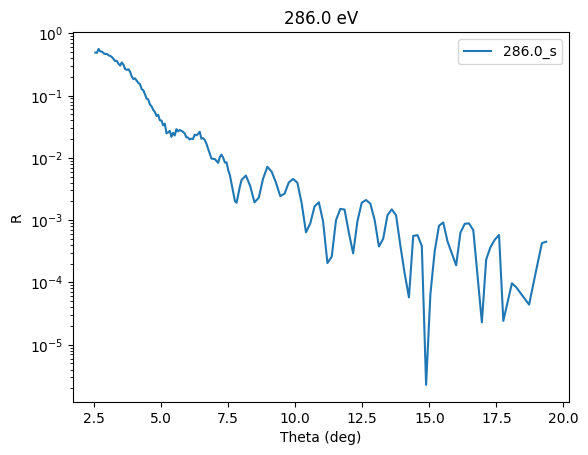

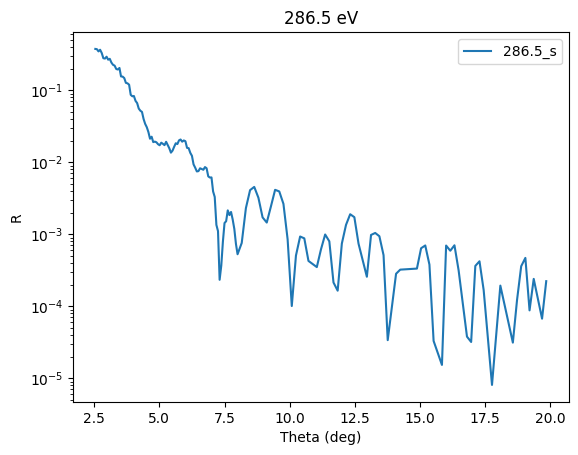

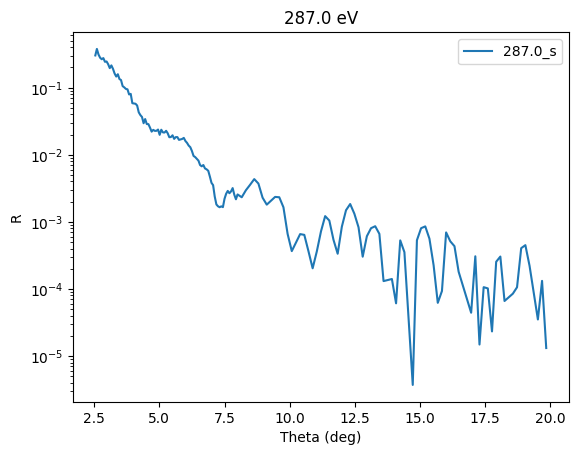

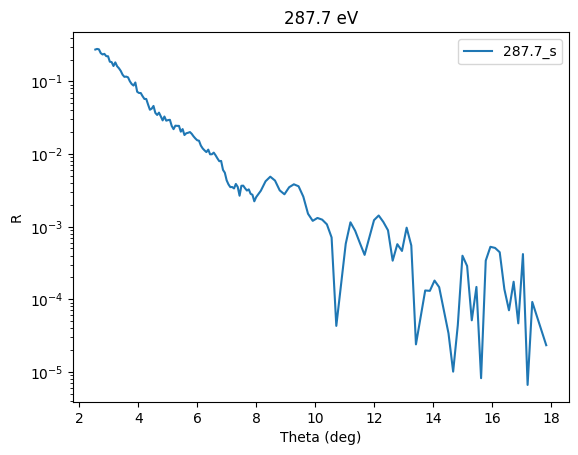

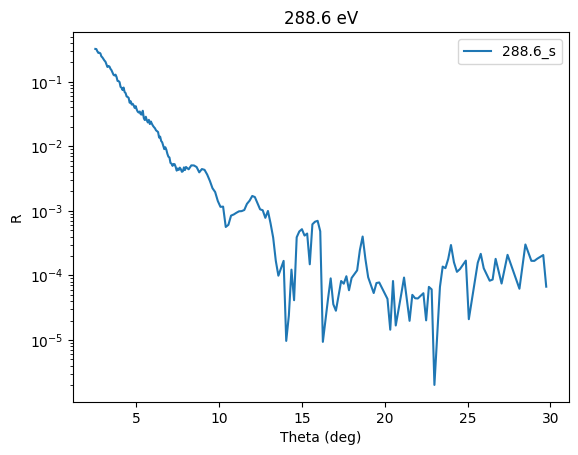

In [3]:
#Plot the relfectivity data for each energy
i_start = 0
i_end = -1
#labels_uni = np.unique(labels)
for i,E in enumerate(energy_uni):
    xrr_all = combined_df[combined_df['E_round']==E] 
    for iden in energy_pol_uni:
        subset = xrr_all[xrr_all['energy_pol'] == iden]
        if not subset.empty:
            plt.plot(subset['Theta'][i_start:i_end], subset['R'][i_start:i_end], '-', label=iden)
    plt.legend()
    plt.yscale('log')
    plt.xlabel('Theta (deg)')
    plt.ylabel('R')
    plt.title(str(E)+ ' eV')
    #plt.axvline(x=1, color='cyan')
    plt.show()

### Set up the model

In [4]:
input_file = pd.read_csv('../fit_input/sample1_set_up.csv')
input_file_col = input_file.columns
layers = []

for _, row in input_file.iterrows():
    layer_spec = LayerSpec.from_row(row, energy_pol_uni)
    #print(layer_spec.describe())
    layers.append(layer_spec)




In [6]:
model = ReflectivityModel(
    energy_pol_uni=energy_pol_uni,
    layers=layers,
    global_params={
        'aoi_offset': {'fit': True, 'x0': 0.0, 'bounds': (-1, 1)},
        'darkcurrent': {'fit': False, 'x0': 0.0},
        'a': {'fit': False, 'x0': 0.045},
        'b': {'fit': False, 'x0': 2.5e-5},
        #'c': {'fit': False, 'value': 2.5e-5}
    },
    fit_strategy="global", #"per_energy",
    sigma_mode="model",
    #sigma_function=custom_sigma
)

model.initialize_keys_from_x0()
model.summarize_stack(energy_pol_uni[0])
model.describe_sigma()


📐 Stack Summary at 250.0_s eV
Layer          |   Thick. :            Bounds |   Rough. :            Bounds |    Δ (n) :            Bounds |    β (k) :            Bounds
------------------------------------------------------------------------------------------------------------------------
🔹 UL             |   35.000 :  [30.000, 40.000] |    0.010 :    [0.000, 1.000] |   0.0033 : [-0.1000, 0.1000] |   0.0009 :  [0.0000, 0.1000]
🔹 oxide          |    1.100 :                 — |    0.100 :                 — |   0.0055 :                 — |   0.0021 :                 —
🔹 substrate      |        — :                 — |    0.100 :                 — |   0.0060 :                 — |   0.0043 :                 —


'σ² = (a·R)² + b² (model-based error)'

In [7]:
def custom_sigma(R, model):
    return model.keys['a'] * R**2 + model.keys['b'] * R + model.keys['c']


model = ReflectivityModel(
    energy_pol_uni=energy_pol_uni,
    layers=[
        LayerSpec("UL")
            .fit_thickness(95, delta=7)
            .fit_roughness(0.01, bounds=(0, 2))
            .fit_nk_from_material('SiO4C8H20', energy_pol_uni, bounds_n=(-0.01, 0.01), bounds_k=(0, 0.01), density=2.5),
        LayerSpec("oxide")
            .fixed_thickness(1.1)
            .fixed_roughness(0.01)
            .fixed_nk_from_material("SiO2", energy_pol_uni, density=2.09),
        LayerSpec("substrate", is_substrate=True)
            .fixed_roughness(0.01)
            .fixed_nk_from_material("Si", energy_pol_uni, density=2.33)
    ],
    global_params={
        'aoi_offset': {'fit': True, 'x0': 0.0, 'bounds': (-1, 1)},
        'darkcurrent': {'fit': False, 'x0': 0.0},
        'a': {'fit': False, 'x0': 0.045},
        'b': {'fit': False, 'x0': 2.5e-5},
        #'c': {'fit': False, 'value': 2.5e-5}
    },
    fit_strategy="per_energy", #"per_energy",
    sigma_mode="model",
    #sigma_function=custom_sigma
)

model.initialize_keys_from_x0()
model.summarize_stack(energy_pol_uni[0])
model.describe_sigma()
#model.energy_index_map


📐 Stack Summary at 250.0_s eV
Layer          |   Thick. :            Bounds |   Rough. :            Bounds |    Δ (n) :            Bounds |    β (k) :            Bounds
------------------------------------------------------------------------------------------------------------------------
🔹 UL             |   95.000 : [88.000, 102.000] |    0.010 :    [0.000, 2.000] |   0.0065 : [-0.0100, 0.0100] |   0.0010 :  [0.0000, 0.0100]
🔹 oxide          |    1.100 :                 — |    0.010 :                 — |   0.0055 :                 — |   0.0021 :                 —
🔹 substrate      |        — :                 — |    0.010 :                 — |   0.0060 :                 — |   0.0043 :                 —


'σ² = (a·R)² + b² (model-based error)'

In [8]:
import json

config = model.to_config()

with open("reflectivity_model_config.json", "w") as f:
    json.dump(config, f, indent=2)



In [9]:
import json

with open("reflectivity_model_config.json") as f:
    config = json.load(f)

model = ReflectivityModel.from_config(config)

model.initialize_keys_from_x0()
model.summarize_stack(energy_pol_uni[0])
model.describe_sigma()


📐 Stack Summary at 250.0_s eV
Layer          |   Thick. :            Bounds |   Rough. :            Bounds |    Δ (n) :            Bounds |    β (k) :            Bounds
------------------------------------------------------------------------------------------------------------------------
🔹 UL             |   95.000 :         [88, 102] |    0.010 :            [0, 2] |   0.0065 : [-0.0100, 0.0100] |   0.0010 :  [0.0000, 0.0100]
🔹 oxide          |    1.100 :                 — |    0.010 :                 — |   0.0055 :                 — |   0.0021 :                 —
🔹 substrate      |        — :                 — |    0.010 :                 — |   0.0060 :                 — |   0.0043 :                 —


'σ² = (a·R)² + b² (model-based error)'

### Do the fit

In [10]:


x0_global, bounds_global, global_keys = model.get_global_fit_params()
#objective_model_fit(x0_global,model, combined_df)

x0_energy = [d['x0'] for d in model.domain_E_init]
bounds_energy = [d['domain'] for d in model.domain_E_init]

model.fit_strategy="per_energy"
x0 =x0_global #+ x0_energy
bounds = bounds_global #+ bounds_energy

res = differential_evolution(
    func=objective.objective_model_fit,
    bounds=bounds,
    args=(model, combined_df),
    strategy='best1bin',       # default strategy
    maxiter=500,              # increase for deeper convergence
    popsize=15,                # population size multiplier
    tol=1e-6,                  # convergence tolerance
    mutation=(0.5, 1.0),       # mutation range
    recombination=0.7,         # crossover probability
    polish=True,               # refine with local search at the end
    disp=True,                  # print progress
    workers=39,
    #x0=x0
)

/home/kas/Projects/.venv/lib/python3.12/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


differential_evolution step 1: f(x)= 255690.32661657
differential_evolution step 2: f(x)= 246721.0997082324
differential_evolution step 3: f(x)= 246721.0997082324
differential_evolution step 4: f(x)= 246721.0997082324
differential_evolution step 5: f(x)= 246019.2915005528
differential_evolution step 6: f(x)= 246019.2915005528
differential_evolution step 7: f(x)= 246019.2915005528
differential_evolution step 8: f(x)= 246019.2915005528
differential_evolution step 9: f(x)= 246019.2915005528
differential_evolution step 10: f(x)= 240575.620108441
differential_evolution step 11: f(x)= 240575.620108441
differential_evolution step 12: f(x)= 240575.620108441
differential_evolution step 13: f(x)= 240346.69902198922
differential_evolution step 14: f(x)= 240346.69902198922
differential_evolution step 15: f(x)= 240346.69902198922
differential_evolution step 16: f(x)= 240346.69902198922
differential_evolution step 17: f(x)= 240346.69902198922
differential_evolution step 18: f(x)= 238319.66159692398


In [11]:
x0_global, bounds_global, global_keys = model.get_global_fit_params()
nk_E, R_E, chi_E, chi_total = objective.objective_model_fit(res.x, model, combined_df, return_all=True)

fitted_nk_layers = [
    layer.name
    for layer in model.layers
    if (
        ('n' in layer.params and layer.params['n'].get('fit', False)) or
        ('k' in layer.params and layer.params['k'].get('fit', False))
    )
]

fitted_globals = {
    name: value
    for name, value in zip(global_keys, res.x[:len(global_keys)])
}

fitted_nk = extract_nk_arrays(nk_E, model.energy_pol_uni, fitted_nk_layers)
fit_para = {**fitted_globals, **fitted_nk}

config = model.to_config(fit_para=fit_para)#,x_global = res.x[:len(global_keys)],nk_E=nk_E)
with open(sample_name + "_reflectivity_model_config.json", "w") as f:
    json.dump(config, f, indent=2)

#config['layers']
#fit_para
#fitted_globals
#updated_params = update_global_params_with_fit(config['global_params'], fitted_globals)
#updated_params

### save as csv and plot

In [12]:
x0_global, bounds_global, global_keys = model.get_global_fit_params()
nk_E, R_E, chi_E, chi_total = objective.objective_model_fit(res.x, model, combined_df, return_all=True)

model.save_all_fit_outputs(
    combined_df=combined_df,
    R_E=R_E,
    nk_E=nk_E,
    x_global=res.x[:len(global_keys)],
    folder_path="../fit_outputs",
    sample_name=sample_name
)

✅ Fit outputs saved to '../fit_outputs' with sample '2layers' and timestamp 20250922_115038


['250.0_s', '284.0_s', '284.2_s', '284.6_s', '285.0_s', '285.5_s', '286.0_s', '286.5_s', '287.0_s', '287.7_s', '288.6_s']


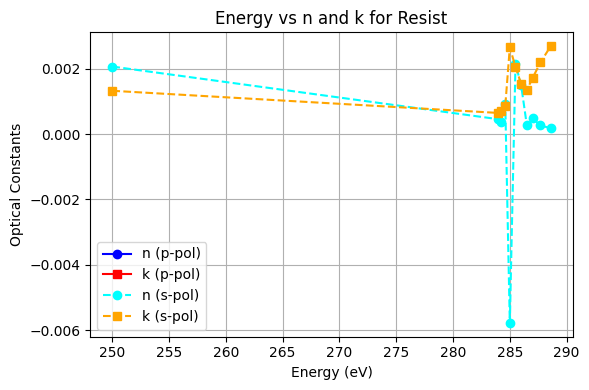

In [13]:
nk_E, R_E, chi_E, chi_total = objective.objective_model_fit(
    res.x, model, combined_df, return_all=True
)
def extract_nk_for_layer(nk_E, layer_index):
    n_vals = [nk[layer_index * 2] for nk in nk_E]
    k_vals = [nk[layer_index * 2 + 1] for nk in nk_E]
    return n_vals, k_vals

def split_energy_by_polarization(energy_pol_uni, n_vals, k_vals):
    energy_p, n_p, k_p = [], [], []
    energy_s, n_s, k_s = [], [], []

    for label, n, k in zip(energy_pol_uni, n_vals, k_vals):
        energy_str, pol = label.split('_')
        energy = float(energy_str)

        if pol == 'p':
            energy_p.append(energy)
            n_p.append(n)
            k_p.append(k)
        elif pol == 's':
            energy_s.append(energy)
            n_s.append(n)
            k_s.append(k)

    return (energy_p, n_p, k_p), (energy_s, n_s, k_s)

energy_pol_uni = model.energy_pol_uni
n_vals = [nk[0] for nk in nk_E]  # assuming index 0 is n
k_vals = [nk[1] for nk in nk_E]  # assuming index 1 is k
print(energy_pol_uni)

def plot_nk_vs_energy_pol(energy_p, n_p, k_p, energy_s, n_s, k_s, layer_name="Layer"):
    plt.figure(figsize=(6, 4))

    # p-polarization
    plt.plot(energy_p, n_p, 'o-', label='n (p-pol)', color='blue')
    plt.plot(energy_p, k_p, 's-', label='k (p-pol)', color='red')

    # s-polarization
    plt.plot(energy_s, n_s, 'o--', label='n (s-pol)', color='cyan')
    plt.plot(energy_s, k_s, 's--', label='k (s-pol)', color='orange')

    plt.xlabel('Energy (eV)')
    plt.ylabel('Optical Constants')
    plt.title(f'Energy vs n and k for {layer_name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

n_vals, k_vals = extract_nk_for_layer(nk_E, layer_index=0)
(energy_p, n_p, k_p), (energy_s, n_s, k_s) = split_energy_by_polarization(model.energy_pol_uni, n_vals, k_vals)
plot_nk_vs_energy_pol(energy_p, n_p, k_p, energy_s, n_s, k_s, layer_name="Resist")

#n_vals, k_vals = extract_nk_for_layer(nk_E, layer_index=1)
#(energy_p, n_p, k_p), (energy_s, n_s, k_s) = split_energy_by_polarization(model.energy_pol_uni, n_vals, k_vals)
#plot_nk_vs_energy_pol(energy_p, n_p, k_p, energy_s, n_s, k_s, layer_name="Resist")


🔧 Fitted Parameters:
aoi_offset : 0.720940
thickness_UL : 101.989799
rough_UL : 1.876879


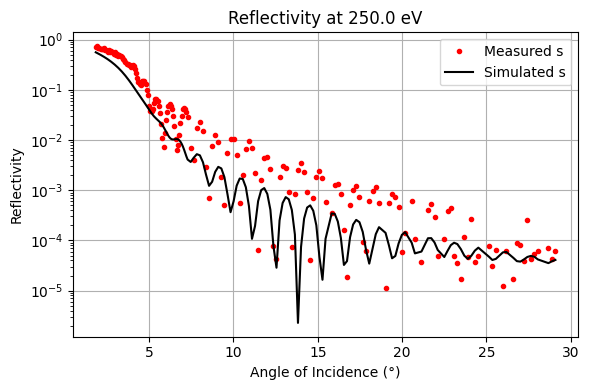

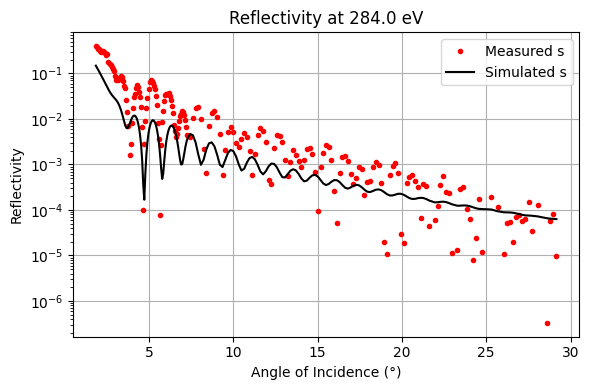

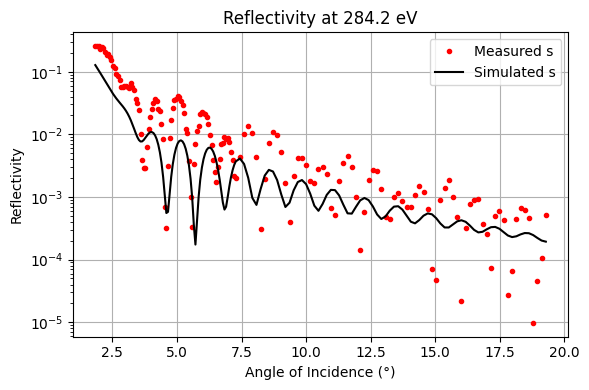

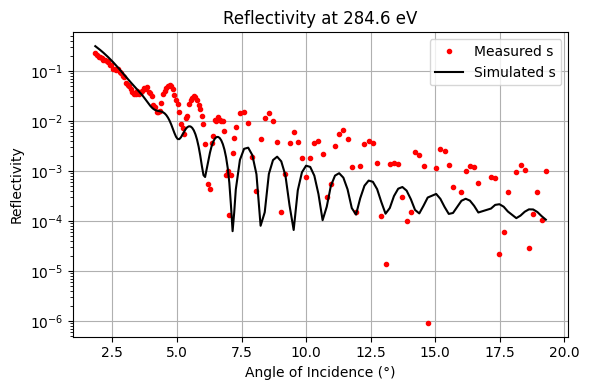

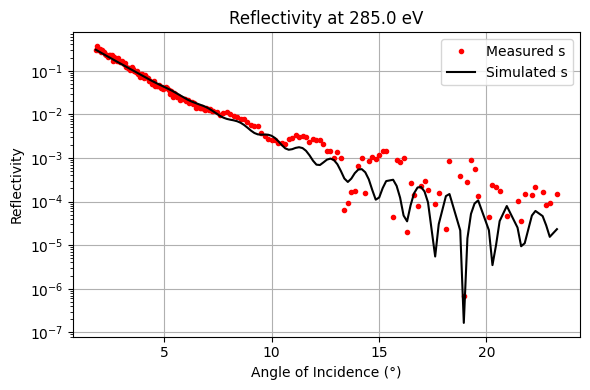

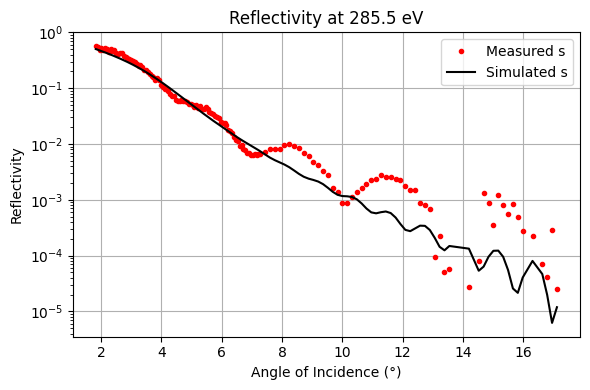

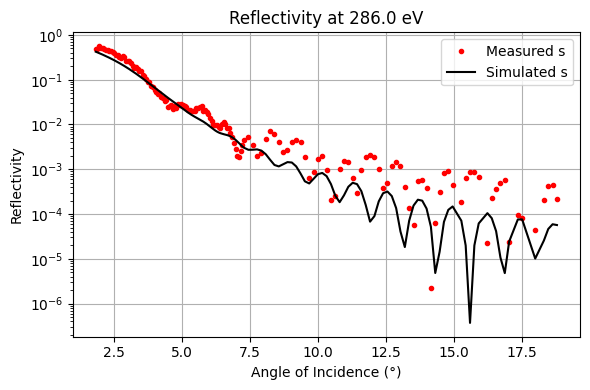

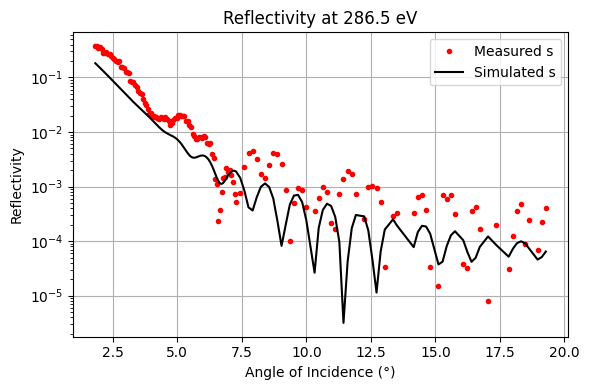

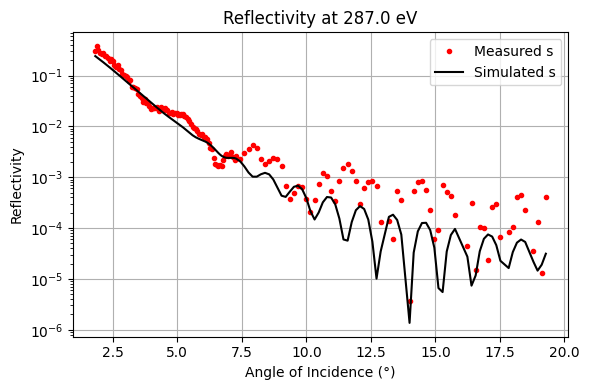

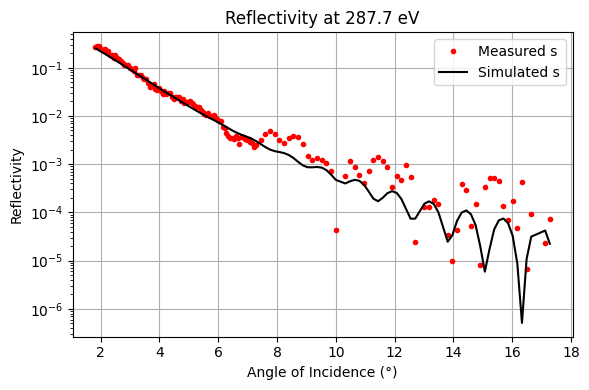

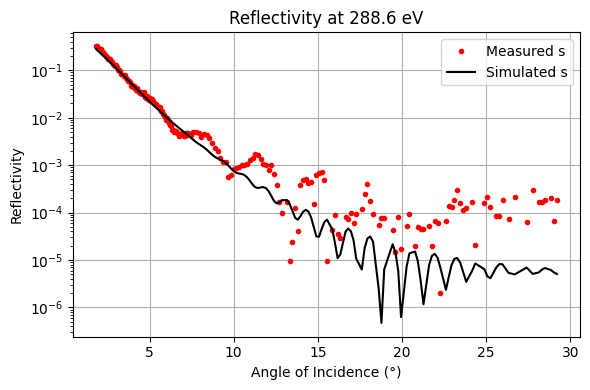

In [14]:
# Reconstruct keys
x_opt = res.x

# Get global keys
x0_global, bounds_global, global_keys = model.get_global_fit_params()
n_global = len(global_keys)

# Get energy-dependent keys
energy_keys = [d['name'] for d in model.domain_E_init]

# Combine all keys
all_keys = global_keys #+ energy_keys

# Print results
print("\n🔧 Fitted Parameters:")
for name, value in zip(all_keys, x_opt):
    print(f"{name} : {value:.6f}")

nk_E, R_E, chi_E, chi_total = objective.objective_model_fit(
    res.x, model, combined_df, return_all=True
)

import matplotlib.pyplot as plt

def plot_reflectivity_results(model, combined_df, R_E):
    # Extract unique energies from energy_pol labels
    energy_values = sorted(set(float(ep.split('_')[0]) for ep in model.energy_pol_uni))

    for E in energy_values:
        plt.figure(figsize=(6, 4))
        plt.title(f'Reflectivity at {E:.1f} eV')
        plt.xlabel('Angle of Incidence (°)')
        plt.ylabel('Reflectivity')
        plt.yscale('log')
        plt.grid(True)

        for pol in ['s', 'p']:
            label = f"{E:.1f}_{pol}"
            if label not in model.energy_index_map:
                continue

            i = model.energy_index_map[label]['index']
            xrr_all = combined_df[combined_df['energy_pol'] == label]
            if xrr_all.empty:
                continue

            aoi_rad = np.deg2rad(xrr_all['Theta'].values) - np.deg2rad(model.keys['aoi_offset'])
            aoi_deg = np.rad2deg(aoi_rad)
            xrr = xrr_all['R'].values
            rm = R_E[i]

            color = 'red' if pol == 's' else 'blue'
            plt.plot(aoi_deg, xrr, '.', label=f'Measured {pol}', color=color)
            plt.plot(aoi_deg, rm, '-', label=f'Simulated {pol}', color="black")

        plt.legend()
        plt.tight_layout()
        plt.show()


plot_reflectivity_results(model, combined_df, R_E)
